## 라이브러리

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

## 설정

In [66]:
# Hyper Parameter 설정

image_size = 227 # AlexNet의 이미지 입력 크기는 (3,227,227)입니다.
num_epochs = 10 
batch_size = 64

device = ("cuda" if torch.cuda.is_available() else 'cpu')
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print(torch.__version__)
print(device)

1.13.1
cpu


## 데이터셋 준비

In [3]:
# Transform 설정
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor()
])

# 훈련데이터 받기
train_data = datasets.FashionMNIST(
    root = 'data',
    train = True,
    download = True,
    transform = transform
)

# 검증데이터 받기
validation_data = datasets.FashionMNIST(
    root = 'data',
    train = False,
    download = True,
    transform = transform
)

## 데이터로더(DataLoader)

In [67]:
# 전체 데이터 중 일부 데이터를 뽑아 배치를 구성
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=64, shuffle=True)

In [68]:
next(iter(train_loader))[0].size()

torch.Size([64, 1, 227, 227])

In [69]:
next(iter(train_loader))[1].size()

torch.Size([64])

## 데이터 시각화

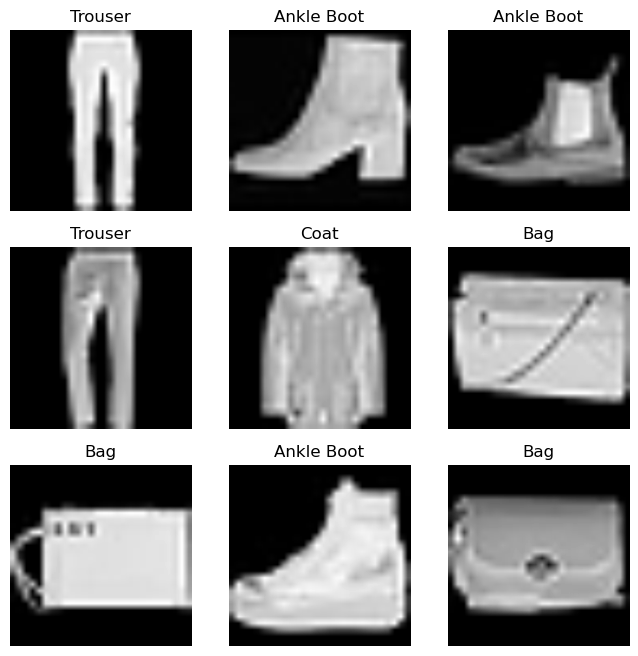

In [4]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8,8))
cols, rows = 3,3
for i in range(1, 10):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

## AlexNet 구현

In [50]:
class AlexNet_fashion_mnist(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=96, kernel_size=11, stride=4, padding=0),
            #input_size : 1x227x227
            #kernel_number : 96
            #output_w : ((227-11)/4) + 1) = 55
            #output_size : 96x55x55
            nn.ReLU(), # size 동일
            nn.MaxPool2d(3,2)
            #((55-3)/2)+1) = 27
            #최종 96x27x27 feature map 생성 
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2),
            #256x27x27
            nn.ReLU(),#256x27x27
            nn.MaxPool2d(3, 2)
            #256x13x13
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1),
            #13 유지
            nn.ReLU()
            #384x13x13
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1),
            #13 유지
            nn.ReLU()
            #384x13x13
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(3, 2)# 13 -> 6
            #256x6x6
        )
        
        
        self.fc1 = nn.Linear(in_features=256*6*6, out_features=4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096,10)
    
    
    def forward(self,x): #input_size = 64x1x227x227
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = out.view(out.size(0),-1)# 64x(256*6*6)
        
        out = F.relu(self.fc1(out))
        out = F.dropout(out, 0.5)
        out = F.relu(self.fc2(out))
        out = F.dropout(out, 0.5)
        out = self.fc3(out)
        out = F.log_softmax(out, dim=1)
        
        return out

## 모델 생성

In [51]:
model = AlexNet_fashion_mnist()
criterion = F.nll_loss # nll_loss : negative log likelihood loss
optimizer = optim.Adam(model.parameters())

## 모델 Summary

In [54]:
from torchsummary import summary as summary_

In [70]:
summary_(model, (1,227,227), batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [64, 96, 55, 55]          11,712
              ReLU-2           [64, 96, 55, 55]               0
         MaxPool2d-3           [64, 96, 27, 27]               0
            Conv2d-4          [64, 256, 27, 27]         614,656
              ReLU-5          [64, 256, 27, 27]               0
         MaxPool2d-6          [64, 256, 13, 13]               0
            Conv2d-7          [64, 384, 13, 13]         885,120
              ReLU-8          [64, 384, 13, 13]               0
            Conv2d-9          [64, 384, 13, 13]       1,327,488
             ReLU-10          [64, 384, 13, 13]               0
           Conv2d-11          [64, 256, 13, 13]         884,992
             ReLU-12          [64, 256, 13, 13]               0
        MaxPool2d-13            [64, 256, 6, 6]               0
           Linear-14                 [6

## Train 정의

In [88]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        target = target.type(torch.LongTensor)
        
        optimizer.zero_grad()
        
        output = model(data)
        loss = criterion(output, target)
        
        loss.backward()
        optimizer.step()
        
        if (batch_idx+1) % 30 == 0 :
            print(f"Train Epoch:{epoch} [{(batch_idx+1)*batch_size}/{len(train_loader.dataset)}] ({100*batch_idx/len(train_loader):.0f})\tLoss:{loss.item():.6f}")

## Test 정의

In [89]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output,target, reduction='sum').item()
            pred = output.max(1)[1]
            correct += pred.eq(target).sum().item()
        
        test_loss /= len(test_loader.dataset)
        print(f"\nTest set: Average loss: {test_loss}, Accuracy: {correct}/{len(test_loader.dataset)} ({100*correct/len(test_loader.dataset)})")
        print('='*50)

## 학습 시작하기

In [90]:
for epoch in range(1, num_epochs+1):
    train(model, train_loader, optimizer, epoch)
    test(model, validation_loader)

KeyboardInterrupt: 